In [ ]:
import gdown
gdown.download("https://drive.google.com/file/d/1YUbTBFrk9QF0ivR5F640G3dhCMC3XQUZ/view?usp=sharing", "dataset.zip", quiet=False, fuzzy=True)
gdown.extractall("dataset.zip")

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
import time
import copy

In [ ]:
torch.manual_seed(3407)

# Create a data transformation pipeline
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = torchvision.datasets.ImageFolder('dataset', transform=transform)
N = len(dataset)
print(f'The number of classes in the dataset = {len(dataset.class_to_idx)}')

N_train = int(0.8 * N)
N_validation = int(0.1 * N)
N_test = N - (N_train + N_validation)
train, validation, test = torch.utils.data.random_split(dataset, (N_train, N_validation, N_test))

print(f'The length of the dataset = {N} instances')
print(f'The length of the training set = {len(train)} instances')
print(f'The length of the validation set = {len(validation)} instances')
print(f'The length of the test set = {len(test)} instances')

batch_size = 64
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(validation, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=2)

The number of classes in the dataset = 2
The length of the dataset = 922 instances
The length of the training set = 737 instances
The length of the validation set = 92 instances
The length of the test set = 93 instances


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Availabe device for training is: {device}')

Availabe device for training is: cpu


In [ ]:
print(dataset.class_to_idx)

{'flooded': 0, 'non-flooded': 1}


In [ ]:
def train_model(model, trainloader, validationloader, device, criterion, optimizer, learning_rate, step_lr_scheduler, epochs):
  model = model.to(device)

  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0


  # Train the model
  for epoch in range(epochs):
      print('-' * 80)
      print(f'Epoch {epoch + 1}/{epochs}')

      for phase in ['train', 'valid']:
          if phase == 'train':
              model.train()
              dataloader = trainloader
              dataset_size = N_train
          else:
              model.eval()
              dataloader = validationloader
              dataset_size = N_validation

          running_loss = 0.0
          running_corrects = 0
          for data in dataloader:
              # Get the training data items of the current batch
              inputs, labels = data
              inputs, labels = inputs.to(device), labels.to(device)

              with torch.set_grad_enabled(phase == 'train'):
                # Forward pass
                outputs = model(inputs)
                # Predict the current batch
                _, preds = torch.max(outputs, 1)
                # Compute loss
                loss = criterion(outputs, labels)

                if phase == 'train':
                  # Set the gradients of all the parameters of the model to zero
                  optimizer.zero_grad()
                  # Backward propagation to calculate the gradient
                  loss.backward()
                  # Update the NN weights by using the gradient
                  optimizer.step()

              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          if phase == 'train':
            step_lr_scheduler.step()

          epoch_loss = running_loss / dataset_size
          epoch_acc = running_corrects.double() / dataset_size

          if phase == 'valid':
            valid_acc.append(epoch_acc)
            valid_loss.append(epoch_loss)
          else:
            train_acc.append(epoch_acc)
            train_loss.append(epoch_loss)

          print('{} loss: {:.4f} --------------- {} accuracy: {:.4f}'.format(phase, epoch_loss, phase, epoch_acc))

          # deep copy the model
          if phase == 'valid' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())


  time_elapsed = time.time() - since
  print('-' * 80)
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best validation accuracy: {:4f}'.format(best_acc))

  # load best model weights
  print('Loading final model weights...')
  model.load_state_dict(best_model_wts)
  return model

In [ ]:
train_acc = []
train_loss = []
valid_acc = []
valid_loss = []

# Training parameters
epochs = 50
learning_rate = 0.001

model = models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Retrain the pre-trained model
model = train_model(model, trainloader, validationloader, device, criterion, optimizer, learning_rate, step_lr_scheduler, epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 307MB/s]


--------------------------------------------------------------------------------
Epoch 1/50
train loss: 0.6018 --------------- train accuracy: 0.7354
valid loss: 0.4809 --------------- valid accuracy: 0.7391
--------------------------------------------------------------------------------
Epoch 2/50
train loss: 0.3593 --------------- train accuracy: 0.9037
valid loss: 0.2669 --------------- valid accuracy: 0.9130
--------------------------------------------------------------------------------
Epoch 3/50
train loss: 0.2093 --------------- train accuracy: 0.9444
valid loss: 0.2015 --------------- valid accuracy: 0.9457
--------------------------------------------------------------------------------
Epoch 4/50
train loss: 0.1392 --------------- train accuracy: 0.9593
valid loss: 0.1541 --------------- valid accuracy: 0.9457
--------------------------------------------------------------------------------
Epoch 5/50
train loss: 0.0758 --------------- train accuracy: 0.9864
valid loss: 0.1362

In [ ]:
if device.type == "cuda":
  train_acc = [train_acc[i].item() for i in range(len(train_acc))]
  valid_acc = [valid_acc[i].item() for i in range(len(valid_acc))]

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

def predict(model, dataloader, device):
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Return the value and the index of the maximum number of the output vector
            _, predicted = torch.max(outputs, 1)

            # Save the predicted values from the model of the current batch
            predicted = predicted.data.cpu().numpy()
            y_pred.extend(predicted)

            labels = labels.data.cpu().numpy()
            y_true.extend(labels)
            
    return np.asarray(y_pred), np.asarray(y_true)

# Test the model on the test dataset
y_pred, y_true = predict(model, testloader, device)
        
classification_report = classification_report(y_true, y_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        48
           1       1.00      0.96      0.98        45

    accuracy                           0.98        93
   macro avg       0.98      0.98      0.98        93
weighted avg       0.98      0.98      0.98        93



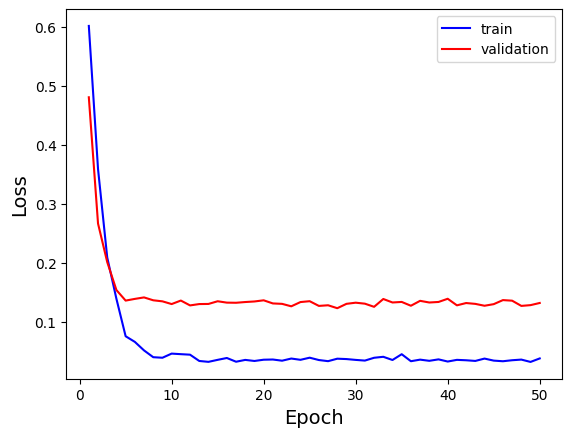

In [ ]:
from matplotlib import pyplot as plt
values = [i for i in range(1, epochs + 1)]
plt.style.use('default')
plt.plot(values, train_loss, color='b', label='train')
plt.plot(values, valid_loss, color='r', label='validation')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend()
plt.show()

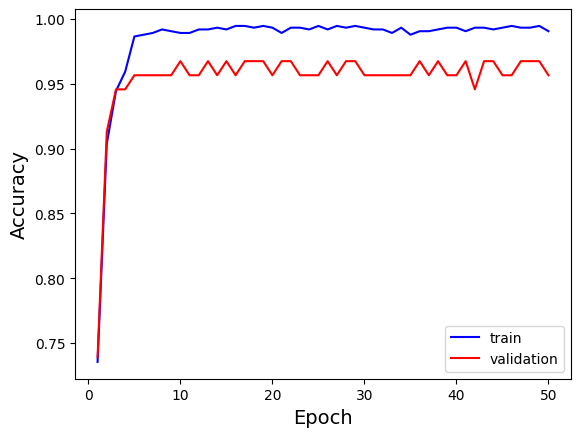

In [ ]:
plt.style.use('default')
plt.plot(values, train_acc, color='b', label='train')
plt.plot(values, valid_acc, color='r', label='validation')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
import shutil
torch.save(model, './resnet50.pth')
drive.mount('/content/drive')
shutil.copy('./resnet50.pth', '/content/drive/MyDrive/Satellite Imaging/SI Project/models')

Mounted at /content/drive


'/content/drive/MyDrive/Satellite Imaging/SI Project/models/resnet50.pth'